In [14]:
import numpy as np
from threeflavorALLvalues import allSigmas
from scipy.integrate import odeint
from solveTmu import blackness
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import brentq, fsolve

from joblib import Parallel, delayed

import matplotlib.pyplot as plt


In [15]:
"Matching Fang paper"
v4=4.2
v3= -22.6/(6*np.sqrt(2))

def chiral(u,y,params):
    chi,chip=y
    v3,v4,lambda1,mu_g,a0,zh,q=params
    
    Q=q*zh**3
    
    
    "Ballon-Bayona version"
    phi = (mu_g*zh*u)**2-a0*(mu_g*zh*u)**3/(1+(mu_g*zh*u)**4)
    phip = 2*u*(zh*mu_g)**2+a0*(4*u**6*(zh*mu_g)**7/(1+(u*zh*mu_g)**4)**2-3*u**2*(zh*mu_g)**3/(1+(u*zh*mu_g)**4))

    f= 1 - (1+Q**2)*u**4 + Q**2*u**6
    fp= -4*(1+Q**2)*u**3 + 6*Q**2*u**5
    "EOM for chiral field"
    derivs=[chip,
            (3/u-fp/f+phip)*chip - (3*chi+lambda1*phi*chi-3*v3*chi**2-4*v4*chi**3)/(u**2*f)]
            #((3+u**4)/(u-u**5) +phip)*chip - (-3*chi+4*v4*chi**3)/(u**2-u**6) ]
            
    return derivs

def chiral_solve_IR(d0,lambda1,T,mu,ui,uf):
    u=np.linspace(ui,uf,1000)
    u_backward=np.linspace(uf,ui,1000)


    zeta=np.sqrt(3)/(2*np.pi)

    mu_g=440
    a0=0

    lambda3=v3
    lambda4=v4


    zh,q = blackness(T,mu)
    Q=q*zh**3
    
    #defining constants for Taylor expansion at horizon u=1

    d1 = (3 * d0 - 3 * d0**2 * lambda3 - 4 * d0**3 * lambda4 + d0 * zh**2 * lambda1 * mu_g**2) / (2 * (-2 + Q**2))

    d2 = (1 / (16 * (-2 + Q**2)**2)) * (6 * d1 * (-6 + Q**2 + Q**4) +
    4 * d0**3 * (14 - 13 * Q**2) * lambda4 + d0**2 * ((42 - 39 * Q**2) * lambda3 - 24 * d1 * (-2 + Q**2) * lambda4) -
    2 * d1 * (-2 + Q**2) * zh**2 * (-8 + 4 * Q**2 - lambda1) * mu_g**2 +
    3 * d0 * (-14 + 13 * Q**2 + 8 * d1 * lambda3 - 4 * d1 * Q**2 * lambda3 + (-2 + 3 * Q**2) * zh**2 * lambda1 * mu_g**2))
    
    "IR boundary condition"
    chi0=d0+d1*(1-uf)
    chip0=d1
    y0=[chi0,chip0]




    params=v3,v4,lambda1,mu_g,a0,zh,q
    
    "solve the EOM using solve_ivp"
    sol = solve_ivp(chiral, [uf, ui], y0, t_eval=u_backward, args=(params,))

    #sol=odeint(chiral,y0,u,args=(params,))
    #plot
    chi=sol.y[0][::-1]
    chip=sol.y[1][::-1]
 
    x=zeta*zh*ui
    #first-order approximation
    mq=chi[0]/(zeta*zh*ui)
    #second-order approximation
    mq1=(x-x*np.sqrt(1-12*v3*chi[0]))/(6*x**2*v3)


    return mq1,chi,chip,u

def sigma_finder(u_intermediate,chi,u,mq,T,mu,zeta,lambda3):
    zh,q = blackness(T,mu)

    "find sigma"
    chi_interp=interp1d(u,chi)
    sigma=(chi_interp(u_intermediate)-mq*zeta*zh*u_intermediate+3*mq**2*zeta**2*lambda3*(zh*u_intermediate)**2)/(u_intermediate*zh)**3*zeta
    return sigma


def chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(chiral_solve_IR)(d0, lambda1, T, mu, ui, uf) for d0 in d0_array
    )
    # Unpack the results
    mq_array, chi_array, chip_array, u_array = zip(*results)
    
    return np.array(mq_array), np.array(chi_array), np.array(chip_array)

In [16]:
#run this to get the initial range of mq vs d0
#mq target should be 50 MeV or some large number
def initial_d0_mq(T,mu,mq_target,lambda1,ui,uf,d0_lower,d0_upper):
    
    d0_array=np.linspace(d0_lower,d0_upper,1000)
    mq_array=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)[0]

    max_d0=d0_upper
    # find the indices where abs(mq_array)>150, and remove those indices from d0_array and mq_array
    indices=np.where(np.abs(mq_array)>150)
    # we don't need to go higher than the lowest d0 value that gives garbage results
    # if indices is not an empty array
    if len(indices[0])>0:
        max_d0=d0_array[indices[0]]
    if len(indices[0])>1:
        max_d0=max_d0[0]

    d0_array=np.delete(d0_array,indices)
    mq_array=np.delete(mq_array,indices)
#     mq1_array=np.delete(mq1_array,indices)
    
    iterations=0
    step_size=d0_array[1]-d0_array[0]
    while mq_array[-1]<mq_target and iterations<20:
    #while max(mq_array)<mq_target and iterations<12:

        #create a new d0_array starting above the maximum value of d0_array, with a spacing that is 1/10 of the spacing of the previous d0_array
        step_size=step_size/10
        d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),step_size)

        # d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),((d0_array[1]-d0_array[0])/100))
        # d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),step_size)
        d0_array=np.concatenate((d0_array,d0_new))
        #calculate the mq_array for the new d0_array
        mq_new=chiral_solve_IR_parallel(d0_new, lambda1, T, mu, ui, uf, n_jobs=-1)[0]
        #add the new mq_array to the old mq_array
        mq_array=np.concatenate((mq_array,mq_new))
#         mq1_array=np.concatenate((mq1_array,mq1_new))

        
        indices=np.where(np.abs(mq_array)>1000)
        # we don't need to go higher than the lowest d0 value that gives garbage results
        # if indices is not an empty array
        if len(indices[0])>0:
            max_d0=d0_array[indices[0]]
        if len(indices[0])>1:
            max_d0=max_d0[0]    
        d0_array=np.delete(d0_array,indices)
        mq_array=np.delete(mq_array,indices)
#         mq1_array=np.delete(mq1_array,indices)

        # print(max_d0)
        old_max_d0=max_d0
        iterations=iterations+1
    # print('iterations',iterations)
    return d0_array,mq_array

/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_83643/648767613.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


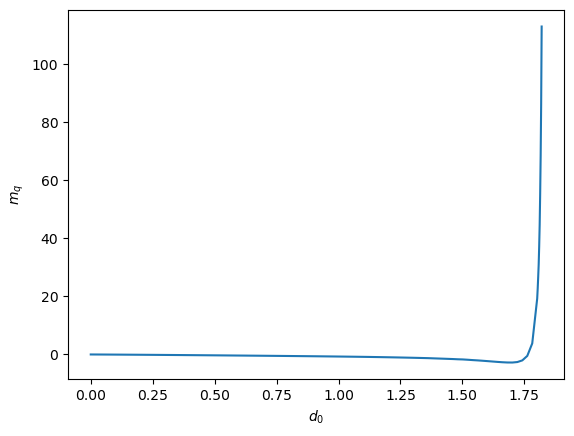

In [116]:
T=50
mu=0
mq_large=50
lambda1=5.6
ui=1e-4
uf=1-ui
d0_lower=0
d0_upper=20
d0_array, mq_array = initial_d0_mq(T, mu, mq_large, lambda1, ui, uf, d0_lower, d0_upper)
plt.plot(d0_array,mq_array)
plt.xlabel(r'$d_0$')
plt.ylabel(r'$m_q$')
plt.show()

In [120]:
T=50
mu=0
ui=1e-4
uf=1-ui

lambda1=5.6

d0_array=np.linspace(1.75,1.82,100)
mq_array,chis,chips=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)


In [122]:
u=np.linspace(ui,uf,len(chips[0]))
lambda3=v3
zeta=np.sqrt(3)/(2*np.pi)
zh,q=blackness(T,mu)
num_uint=38
mq_improved=np.zeros((num_uint,len(d0_array)))
sigma_improved=np.zeros((num_uint,len(d0_array)))
u_int_array=np.zeros(num_uint)
j=0
for i in np.arange(50,1000,25):
    u_int=u[i]
    u_int_array[j]=u_int
    chi0=chis[:,i]
    chip0=chips[:,i]
    mq_improved[j,:]=(1-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*lambda3*zeta*u_int*zh)
    sigma_improved[j,:]=zeta*(1-6*chi0*lambda3+3*chip0*u_int*lambda3-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*u_int**3*zh**3*lambda3)
    j=j+1

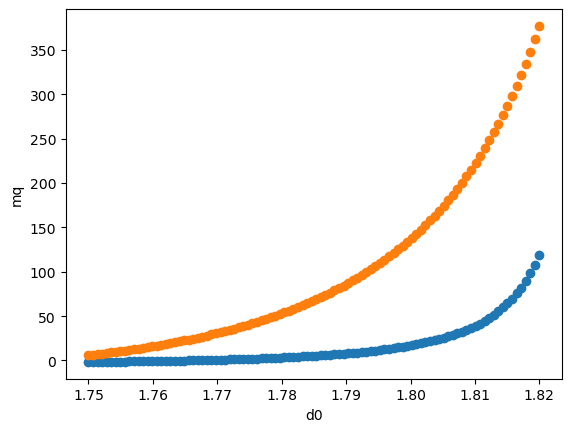

In [130]:
plt.scatter(d0_array,mq_improved[0])
plt.scatter(d0_array,mq_improved[15])
plt.xlabel("d0")
plt.ylabel("mq")
plt.show()

/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_83643/2892787093.py:2: RuntimeWarning: invalid value encountered in power
  plt.scatter(mq_improved[j,:],sigma_improved[j,:]**(1/3))


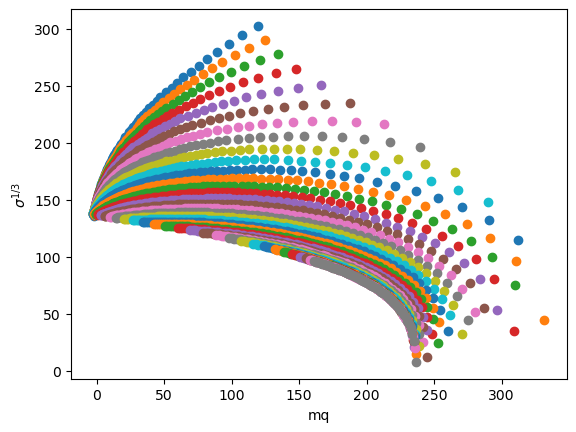

In [124]:
for j in range(len(mq_improved)):
    plt.scatter(mq_improved[j,:],sigma_improved[j,:]**(1/3))
plt.xlabel("mq")
plt.ylabel("$\sigma^{1/3}$")
plt.show()


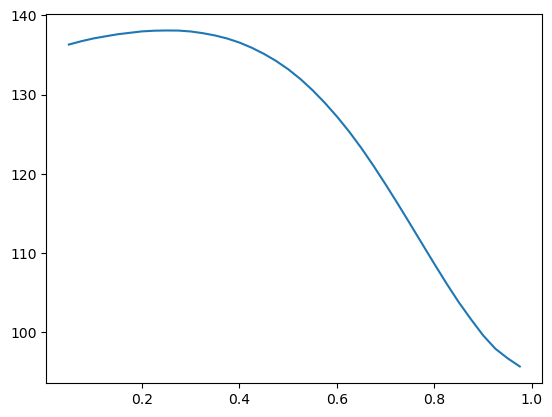

In [125]:
plt.plot(u_int_array,sigma_improved[:,1]**(1/3))
plt.show()

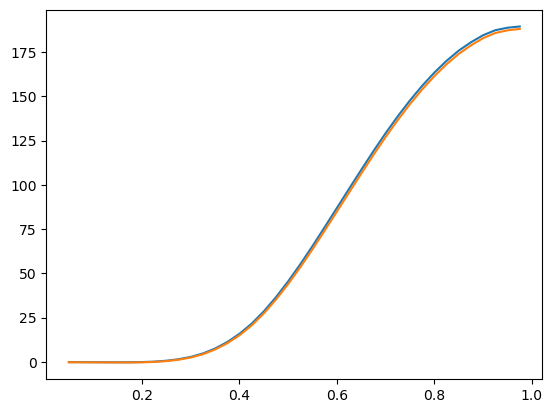

In [126]:
plt.plot(u_int_array,mq_improved[:,20])
plt.plot(u_int_array,mq_improved[:,19])

plt.show()

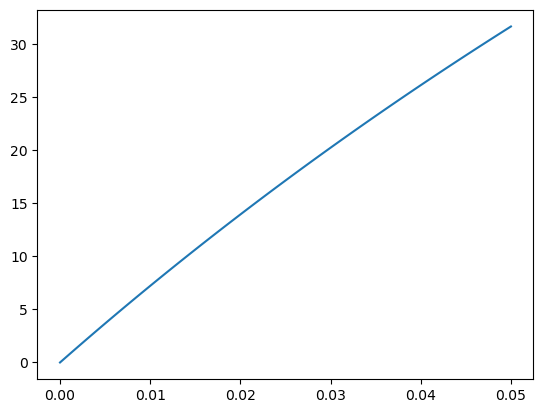

In [24]:
plt.plot(d0_array,mq_improved[20,:])
plt.show()

In [77]:
def find_closest_d0(mq_improved, d0_array, specified_value, sigma_improved):
    # Calculate absolute differences for each value of u_int
    abs_diffs = np.abs(mq_improved - specified_value)
    
    # Get index of smallest difference for each u_int
    indices = np.argmin(abs_diffs, axis=1)
    
    # Get the corresponding d0_array values
    closest_d0_values = d0_array[indices]

    corresponding_mq_values = mq_improved[np.arange(mq_improved.shape[0]), indices]
    corresponding_sigma_values = sigma_improved[np.arange(sigma_improved.shape[0]), indices]

    
    return closest_d0_values, corresponding_mq_values, corresponding_sigma_values


In [131]:
specified_value = 10 # Replace this with the value you want to specify
closest_d0, mq_new, sigma_new= find_closest_d0(mq_improved, d0_array, specified_value, sigma_improved)



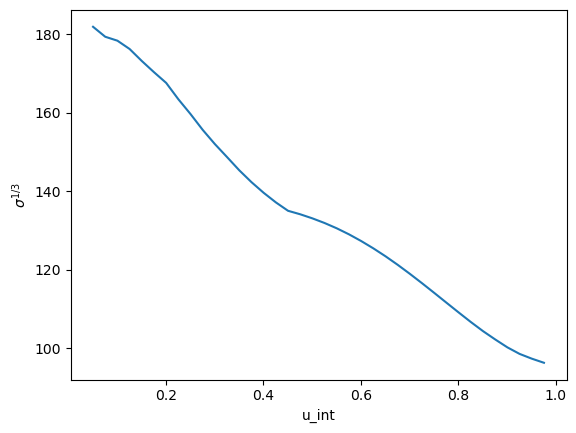

In [132]:
plt.plot(u_int_array,sigma_new**(1/3))
plt.xlabel("u_int")
plt.ylabel("$\sigma^{1/3}$")
plt.show()


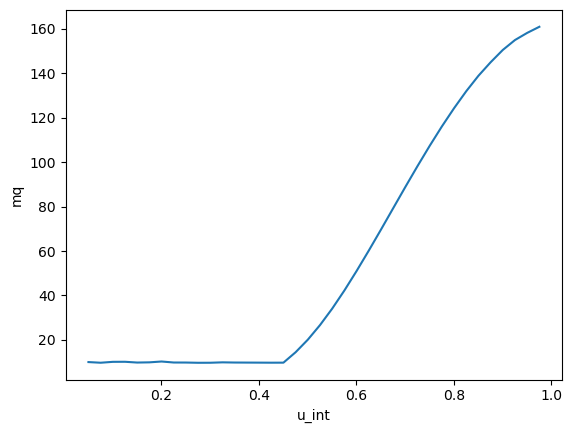

In [133]:
plt.plot(u_int_array,mq_new)
plt.xlabel("u_int")
plt.ylabel("mq")
plt.show()

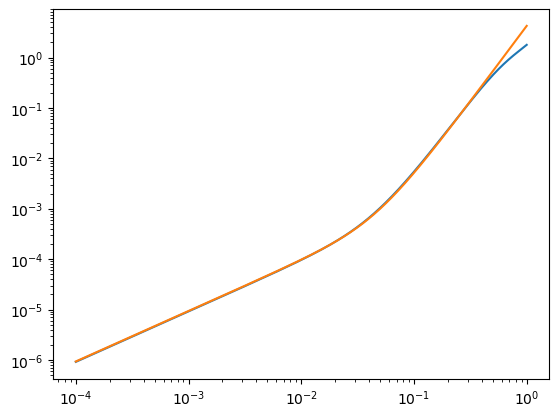

In [218]:
index=50
u_index=0
sl=600
plt.loglog(u,chis[index,:])
plt.loglog(u, u*mq_improved[u_index,index]*zh*zeta-3*(mq_improved[u_index,index]*zeta*zh*u)**2*lambda3 +sl**3/zeta*zh**3*zeta**3*u**3)
plt.show()

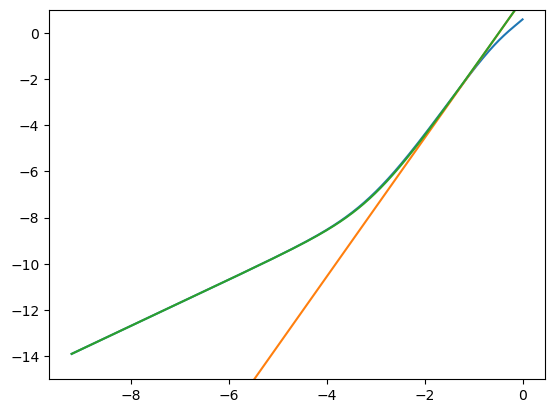

In [216]:
sl=600
plt.plot(np.log(u),np.log(chis[index,:]))
# plt.plot(np.log(u),np.log(u*mq_improved[u_index,index]*zh*zeta-3*(mq_improved[u_index,index]*zeta*zh*u)**2*lambda3 +sl**3/zeta*zh**3*zeta**3*u**3))
plt.plot(np.log(u),np.log(sl**3/zeta*zh**3*zeta**3*u**3))
plt.plot(np.log(u),np.log(u*mq_array[index]*zh*zeta-3*(mq_array[index]*zeta*zh*u)**2*lambda3 +sl**3/zeta*zh**3*zeta**3*u**3))
plt.ylim(-15,1)
plt.show()


In [198]:
mq_improved[u_index,index]

-0.23423559014396422

In [194]:
mq_array[50]

5.232825906055072

In [209]:
#output np.log(u) and np.log(chis[index,:]) to a file
np.savetxt('chis.txt',np.transpose([np.log(u),np.log(chis[index,:])]))
